In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [2]:
# Load the dataset
new_df= pd.read_csv('new_df.csv')

# Define X and y
X_ml = new_df.select_dtypes(include='number').drop(columns='Life_expectancy')
y_ml = new_df['Life_expectancy']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

# Scale it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to train
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

# Train & evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    results[name] = {
        'MAE': mean_absolute_error(y_test, preds),
        'MSE': root_mean_squared_error(y_test, preds),
        'RMSE': root_mean_squared_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    }

# Create results DataFrame
results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print(results_df)

                       MAE       MSE      RMSE        R2
XGBoost           1.138150  1.844077  1.844077  0.942763
RandomForest      1.142233  1.890254  1.890254  0.939861
LinearRegression  2.194558  2.903635  2.903635  0.858094
Ridge             2.196396  2.905102  2.905102  0.857950
Lasso             2.684687  3.394047  3.394047  0.806111


From the above analysis, it can be concluded that **XGBoost** is the 'best model' as it has the highest R2 and the lowest MAE and RMSE.

In [3]:
# Cross-validation check

from sklearn.model_selection import cross_val_score

best_model = models['XGBoost']
scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Mean R² (5-Fold CV): {scores.mean():.3f}")
print(f"All R² Scores: {scores}")

Mean R² (5-Fold CV): 0.932
All R² Scores: [0.90239553 0.94983786 0.92586888 0.95492592 0.92582012]


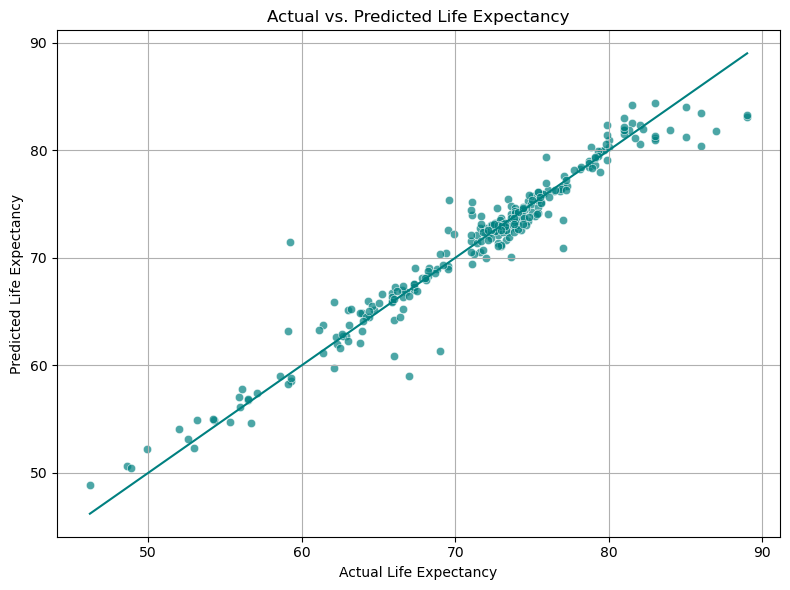

In [4]:
# Actual vs Predicted plot

import matplotlib.pyplot as plt
import seaborn as sns

# Choosing the XGBoost as the best model 
best_preds = best_model.predict(X_test_scaled)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=best_preds, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='teal', linestyle='-')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs. Predicted Life Expectancy')
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig('plots/Actual_vs_Predicted.png')
plt.show()

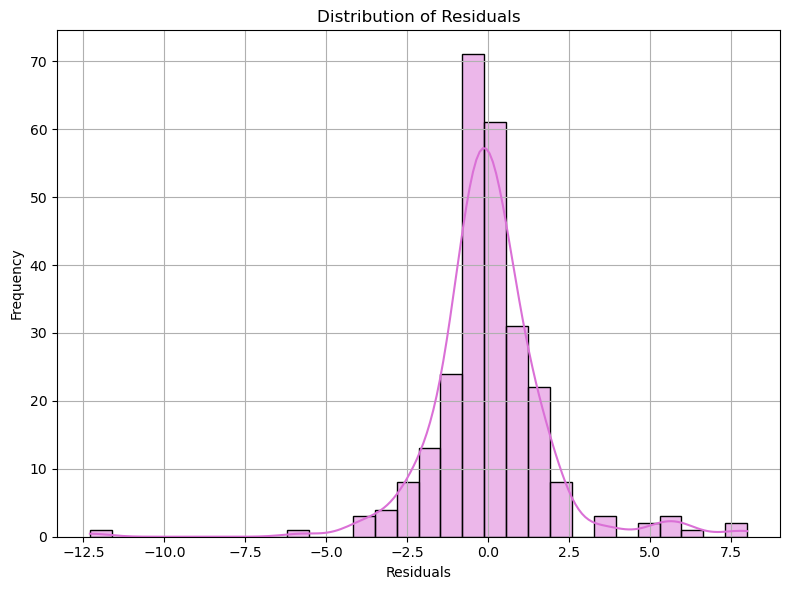

In [5]:
# Residual plot

residuals = y_test-best_preds

plt.figure(figsize= (8, 6))
sns.histplot(residuals, kde= True, bins= 30, color='orchid')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig('plots/Residual_plot.png')
plt.show()

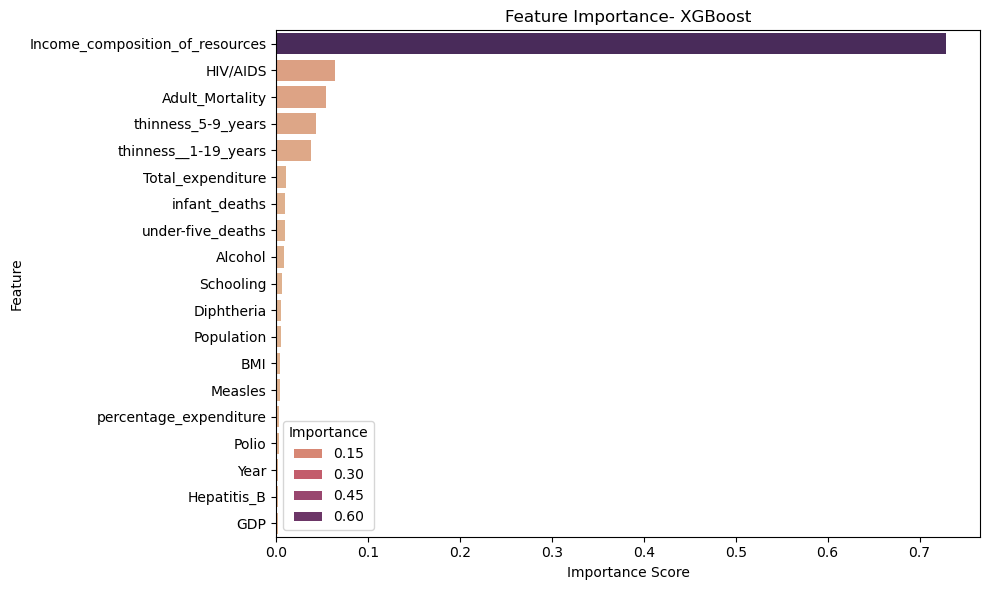

In [6]:
# Feature Importance

import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by= 'Importance', ascending= False)

# Plot
plt.figure(figsize= (10, 6))
sns.barplot(data= feat_imp_df, x='Importance', y='Feature', hue='Importance', palette='flare')
plt.title(f'Feature Importance- XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# Save and show
plt.savefig('plots/Feature_Importance.png')
plt.show()

In [7]:
# Hyperparameter Tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV

# Define the param grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get best estimator
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

best_rf_preds = best_rf_model.predict(X_test_scaled)
print(f"R²: {r2_score(y_test, best_rf_preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, best_rf_preds):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, best_rf_preds):.3f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R²: 0.943
MAE: 1.181
RMSE: 1.847


In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.
